# Jorual DAO: A New Framework for DeSci in Web 3.0

In [14]:
from math import floor
import pandas as pd
from random import randint
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## type

In [2]:
class IUser():
  address: int
  token: int
  def __init__(self, address:str, token:int) -> None:
    self.address = address
    self.token = token

class IReview(IUser):
  rating: int
  def __init__(self, address:str, rating:int) -> None:
    self.rating = rating
    super().__init__(address, 0)

class IAuthor(IUser):
  sequence: int
  weight: int
  def __init__(self, address:str, sequence:int) -> None:
    self.sequence = sequence
    super().__init__(address, 0)

class ICitedBy(IUser):
  articleID: int
  def __init__(self, address:str, articleID:int) -> None:
    self.articleID = articleID
    super().__init__(address, 0)



## dao class

In [42]:
class ArticleDAO:
  _distribution:list[IUser]
  _articleID = None
  _authors:list[IAuthor]
  _reviewers:list[IReview]
  _downloads:list[IUser]
  _cites:list[ICitedBy]
  _holder =pd.DataFrame()
  _log = pd.DataFrame()
  _finance = pd.DataFrame()
  DOWNLOAD_FEE = 1
  AUTHOR_TOKEN = 1000
  REVIEW_TOKEN = 2000
  DOWNLOAD_TOKEN = 12
  CITE_TOKEN = 24
  def __init__(self, articleID:int, authors:list[str]):
    self._articleID = articleID
    self._authors = list()
    for i, author in enumerate(authors):
      self._authors.append(IAuthor(author, i))
    self._reviewers = list()
    self._downloads = list()
    self._cites = list()
    self._distribution = list()

  def review(self, reviews:list[IReview]):
    total = sum(review.rating for review in reviews)
    for review in reviews:
      rating = 0
      if review.rating >= 5:
        rating = 5
      elif review.rating <= 1:
        rating = 1
      else:
        rating = review.rating
      review.token = floor(rating  / total * self.REVIEW_TOKEN)
    self._reviewers = reviews

    weight_len = 0
    for i, author in enumerate(self._authors):
      if i == 0 or i == 1:
        author.weight = 5
      elif i == 2:
        author.weight = 2
      else:
        author.weight = 1
      weight_len += author.weight
    for i, author in enumerate(self._authors):
      author.token = floor((author.weight / weight_len) * self.AUTHOR_TOKEN)
    self.record()

  def download(self, address:str):
    user = next((obj for obj in self._downloads if obj.address == address), None)
    if user:
      return
      # user.token = user.token + 1
    else:
      self._downloads.append(IUser(address, self.DOWNLOAD_TOKEN))
    total = sum(author.token for author in self._authors if author.token > 1)
    for author in self._authors:
      author.token += floor((author.token / total) * self.DOWNLOAD_TOKEN)
    self.record()

  def cite(self, address:str):
    user = next((obj for obj in self._cites if obj.address == address), None)
    if user:
      user.token = user.token + self.CITE_TOKEN
    else:
      self._cites.append(IUser(address, self.CITE_TOKEN))
    total = sum(author.token for author in self._authors)
    for author in self._authors:
      author.token += floor((author.token / total) * self.DOWNLOAD_TOKEN)
    self.record(True)

  def record(self, cite:bool=False):
    data = {}
    total = 0
    for obj in self._authors:
      data[obj.address] = [obj.token]
      total += obj.token

    for obj in self._reviewers:
      data[obj.address] = [obj.token]
      total += obj.token

    if len(self._cites) > 0:
      data['cite'] = self.CITE_TOKEN
    else: 
      data['cite'] = 0
    total += len(self._cites) * self.CITE_TOKEN

    if len(self._downloads) > 0:
      data['download'] = self.DOWNLOAD_TOKEN
    else:
      data['download'] = 0
    total += len(self._downloads) * self.DOWNLOAD_TOKEN

    row = pd.DataFrame(data)
    self._holder = pd.concat([self._holder, row], ignore_index=True)
    frac = row.divide(total, axis=0)
    self._log = pd.concat([self._log, frac], ignore_index=True)
    if not cite:
      self._finance = pd.concat([self._finance, frac * self.DOWNLOAD_FEE], ignore_index=True)
  
  def emulate(self, download:int, cite:int):
    arr = []
    for i in range(download):
      arr.append({'address':'u' + str(i), 'type':'d'})
    for i in range(cite):
      index = randint(0, len(arr) - 1)
      arr.insert(index, {'address':'u' + str(randint(0,index)), 'type':'c'})
    for d in arr:
      if d['type'] == 'd':
        self.download(d['address'])
      else:
        self.cite(d['address'])
  
  def show(self):
    return self._log
  
  def proportion(self):
    self._log.plot(title='Proportion')

  def revenue(self, names:list[str] = []):
    df = self._finance.copy()
    # if len(names) == 0:
    #   names = df.columns
    for name in df.columns:
      df[name] = self._finance[name].cumsum()
    df.plot(title='Revenue')

  def revenue_user(self):
    # 显示清除下载者入场时间
    df = pd.DataFrame()
    for name in ['download', 'cite']:
      df[name] = self._finance[name].cumsum()
    ax = df.plot(title='Revenue')
    ax.axhline(y=1, color='r', linestyle='--')
  
  def holder(self):
    return self._holder
  
  def finance(self):
    column_sums = self._finance.sum()
    self._finance.loc['Total'] = column_sums
    return self._finance
    

## run instance

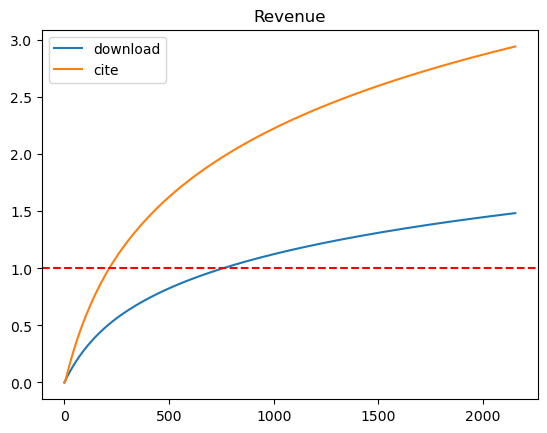

In [44]:
article = ArticleDAO(1, ['Corresponding', 'Author1','Author2','Author3'])
article.review([IReview(address='reviewer1', rating=4), IReview(address='reviewer2', rating=5), IReview(address='reviewer3', rating=3)])

# article.emulate(20, 1)
article.emulate(2154, 42)

# article.show()
# article.revenue(names=['download', 'cite'])
article.revenue_user()

In [5]:
article.holder()

,Corresponding,Author1,Author2,Author3,reviewer1,reviewer2,reviewer3,cite,download
0,384,384,153,76,666,833,500,0,0
1,388,388,154,76,666,833,500,0,12
2,392,392,155,76,666,833,500,0,12
3,396,396,156,76,666,833,500,0,12
4,400,400,157,76,666,833,500,0,12
...,...,...,...,...,...,...,...,...,...
2192,11218,11218,2345,76,666,833,500,24,12
2193,11223,11223,2346,76,666,833,500,24,12
2194,11228,11228,2347,76,666,833,500,24,12
2195,11233,11233,2348,76,666,833,500,24,12


In [19]:
article.finance()

,Corresponding,Author1,Author2,Author3,reviewer1,reviewer2,reviewer3,cite,download
0,0.128171,0.128171,0.051068,0.025367,0.222296,0.278037,0.166889,0.000000,0.000000
1,0.128605,0.128605,0.051044,0.025191,0.220749,0.276102,0.165728,0.000000,0.003977
2,0.129032,0.129032,0.051020,0.025016,0.219223,0.274194,0.164582,0.000000,0.003950
3,0.129454,0.129454,0.050997,0.024845,0.217718,0.272311,0.163452,0.000000,0.003923
4,0.129870,0.129870,0.050974,0.024675,0.216234,0.270455,0.162338,0.000000,0.003896
...,...,...,...,...,...,...,...,...,...
2151,0.209045,0.209045,0.043698,0.001416,0.012405,0.015516,0.009313,0.000447,0.000224
2152,0.209049,0.209049,0.043698,0.001415,0.012400,0.015509,0.009309,0.000447,0.000223
2153,0.209052,0.209052,0.043698,0.001414,0.012395,0.015503,0.009305,0.000447,0.000223
2154,0.209056,0.209056,0.043697,0.001414,0.012389,0.015496,0.009301,0.000446,0.000223


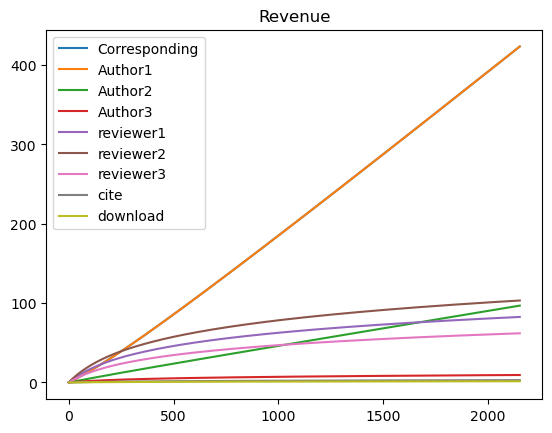

In [45]:
article.revenue()

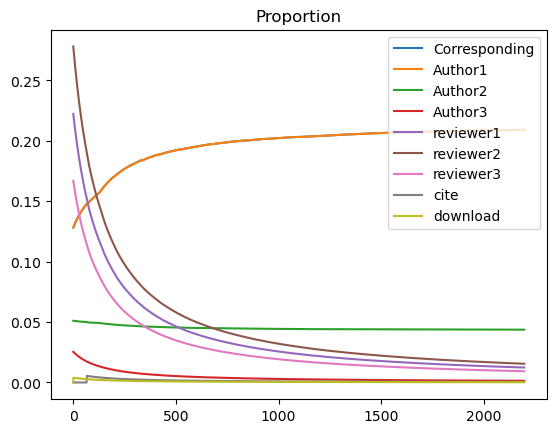

In [39]:
article.proportion()

In [22]:
df = pd.DataFrame({
    'out': [20, 2154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'in': [1000, 2000, 1500, 3000, 2500, 1800, 2800, 2200, 1900, 2100, 2400, 2700]
})
for name in df.columns:
  print(name)

out
in
